# Interactive User Segmentation with Clustering

This notebook implements a full user-segmentation pipeline—starting from raw review data in Spark, through feature engineering and dimensionality reduction, all the way to interactive clustering visualizations.  By selecting different algorithms and tuning hyperparameters on the fly, you can discover and refine customer segments that drive personalized marketing, product improvements, and loyalty programs.

---

## Step-by-Step Process

1. **Setup & Imports**  
   - Load Spark, Pandas, ML libraries (scikit-learn, SciPy, IPyWidgets).  
2. **Data Ingestion**  
   - Read the master Parquet review dataset into Spark and cache it for fast reuse.  
3. **Review-Level Feature Engineering**  
   - Compute per-review metrics:  
     - *Helpfulness ratio* (helpful votes vs. total)  
     - *Review length* (character count)  
     - *Image/video flags*  
4. **User-Level Aggregation & Filtering**  
   - Aggregate to user profiles: average rating, total review count, avg helpfulness, avg length, pct images/videos.  
   - Filter to “active” users (e.g. > 100 reviews) to focus on meaningful behavior.  
5. **Pandas Conversion & Feature Selection**  
   - Collect the filtered Spark DataFrame into Pandas for local ML workflows.  
   - Define key clustering features (e.g. `avg_rating`, `review_count`, `avg_helpfulness`, etc.).  
6. **Scaling & PCA**  
   - Standard-scale features to zero mean/unit variance.  
   - Run PCA to reduce to two principal components—preview explained variance and enable 2D plotting.  
7. **Interactive Clustering Controls**  
   - Provide IPyWidgets for:  
     - **Algorithm**: choose K-Means, DBSCAN, or Agglomerative Clustering  
     - **Hyperparameters**:  
       - K (number of clusters) for K-Means/Agglomerative  
       - ε (epsilon) & min_samples for DBSCAN  
8. **Dynamic Visualization & Evaluation**  
   - On each widget change:  
     - Re-fit the selected model to the scaled data  
     - Compute silhouette score to gauge cluster quality  
     - Render:  
       - **2D scatter** of users in PC1/PC2 space, colored by cluster  
       - **Dendrogram** for hierarchical clustering (if chosen)  

---

### Empowerment & Exploration

By adjusting the algorithm selector and hyperparameter sliders, you can:

- **Compare** how different methods partition your user base  
- **Find** the ideal number of segments via silhouette score peaks  
- **Uncover** actionable personas to drive tailored campaigns  
- **Rapidly prototype** segmentation scenarios and export results for your BI or marketing tools  


## 1. Setup & Imports

In [ ]:
# ─── Data Manipulation ───────────────────────────────────────────────
import pandas as pd
from pyspark.sql import SparkSession, functions as F

# ─── Machine Learning & Clustering ───────────────────────────────────
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# ─── Visualization ───────────────────────────────────────────────────
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

# ─── Interactive Widgets ─────────────────────────────────────────────
import ipywidgets as widgets


In [ ]:
# ———————— Data Ingestion ————————
# a) Via Spark (for large-scale data)
spark = SparkSession.builder \
    .appName("CustomerSegmentation") \
    .getOrCreate()

## 2. Data Ingestion

In [ ]:
path = "gs://ba843-group1-project/master_data.parquet"
df_master = spark.read.parquet(path)

In [ ]:
df_master.cache()

25/04/28 22:41:35 WARN CacheManager: Asked to cache already cached data.


DataFrame[parent_asin: string, asin: string, helpful_vote: bigint, images: array<struct<attachment_type:string,large_image_url:string,medium_image_url:string,small_image_url:string>>, rating: double, text: string, timestamp: bigint, title: string, user_id: string, verified_purchase: boolean, main_category: string, average_rating: double, rating_number: double, features: string, description: string, price: double, videos: string, store: string, categories: string, bought_together: string, Product_title: string]

## 3. Review-Level Feature Engineering

In [ ]:
min_review_count = 100 # Change accordingly to adjust the dataframe by count of reviews per customer.

# ─── 2a) Review-level feature engineering ─────────────────────────────
df_feat = (
    df_master
    # helpfulness ratio
    .withColumn(
        "helpfulness_ratio",
        F.col("helpful_vote") / (F.col("helpful_vote") + 1)
    )
    # text length
    .withColumn("review_length", F.length(F.col("text")))
    # image flag (images is an array)
    .withColumn(
        "has_image",
        F.when(F.size(F.col("images")) > 0, 1).otherwise(0)
    )
    # video flag (videos comes in as JSON string like "[]")
    .withColumn(
        "has_video",
        F.when(F.length(F.col("videos")) > 2, 1).otherwise(0)
    )
)

## 4. User-Level Aggregation & Filtering

In [ ]:
# ─── 2b) Aggregate to user-level ───────────────────────────────────────
user_spark = (
    df_feat
    .groupBy("user_id")
    .agg(
        F.mean("rating"           ).alias("avg_rating"),
        F.count("rating"          ).alias("review_count"),
        F.mean("helpfulness_ratio").alias("avg_helpfulness"),
        F.mean("review_length"    ).alias("avg_review_length"),
        F.mean("has_image"        ).alias("pct_images"),
        F.mean("has_video"        ).alias("pct_videos"),
    )
)


# ─── 2c) Keep only users with more than 100 reviews ────────────────────
user_spark_filtered = user_spark.filter(F.col("review_count") > min_review_count)

## 5. Pandas Conversion,Feature Selection, Scaling & PCA

In [ ]:
# ─── 2d) Bring the filtered user-profile table into pandas ────────────
user_df = user_spark_filtered.toPandas()

In [ ]:
print(f"Kept {user_df.shape[0]} users (each with >100 reviews) and {user_df.shape[1]} features")
user_df.head()

Kept 4399 users (each with >100 reviews) and 7 features


,user_id,avg_rating,review_count,avg_helpfulness,avg_review_length,pct_images,pct_videos
0,AF6SORTNYMHFQ7ZSYQBR4DKR3X7A,3.393701,127,0.328346,262.551181,0.000000,0.173228
1,AFYEPGE3JJZIGGFTKWLFLYFSNKZQ,4.730159,126,0.166119,124.920635,0.857143,0.746032
2,AFO7JNI7QIWMODLGS3WDBA4HGEZQ,4.726415,106,0.056289,272.150943,0.103774,0.641509
3,AEICZD35OTDYVWA2KPYWN4PDZ2SA,4.472325,813,0.125142,306.758918,0.009840,0.334563
4,AGKLTVE3GM5ZP3K6J25JVDTOCBJA,4.395161,124,0.261889,763.661290,0.177419,0.266129


In [ ]:
# 1. Define the features you want to cluster on
features = [
    "avg_rating",
    "review_count",
    "avg_helpfulness",
    "avg_review_length",
    "pct_images",
    "pct_videos",
]

# 2. Scale to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_df[features])

# 3. Run PCA down to 2 dimensions for plotting
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)

# 4. Attach the principal components back to your DataFrame
user_df["pc1"] = pcs[:, 0]
user_df["pc2"] = pcs[:, 1]

# 5. Check how much variance PC1 & PC2 capture
print("Explained variance by PC1 & PC2:", pca.explained_variance_ratio_)

# 6. Preview
user_df.head()

Explained variance by PC1 & PC2: [0.29523548 0.25956294]


,user_id,avg_rating,review_count,avg_helpfulness,avg_review_length,pct_images,pct_videos,pc1,pc2
0,AF6SORTNYMHFQ7ZSYQBR4DKR3X7A,3.393701,127,0.328346,262.551181,0.000000,0.173228,1.477773,3.016060
1,AFYEPGE3JJZIGGFTKWLFLYFSNKZQ,4.730159,126,0.166119,124.920635,0.857143,0.746032,-0.255439,-2.483081
2,AFO7JNI7QIWMODLGS3WDBA4HGEZQ,4.726415,106,0.056289,272.150943,0.103774,0.641509,-1.293206,-0.716562
3,AEICZD35OTDYVWA2KPYWN4PDZ2SA,4.472325,813,0.125142,306.758918,0.009840,0.334563,0.356853,0.644318
4,AGKLTVE3GM5ZP3K6J25JVDTOCBJA,4.395161,124,0.261889,763.661290,0.177419,0.266129,1.711432,0.827732


## 6. Interactive Clustering Controls and Dynamic Visualization & Evaluation

In [ ]:
# ───────────────────────────────────────────────────────────
# Interactive Clustering with Dynamic Hyperparameters & Diagrams
# ───────────────────────────────────────────────────────────

# 1) Controls
algo_dropdown = widgets.Dropdown(
    options=['KMeans','DBSCAN','Agglomerative'],
    value='KMeans',
    description='Algorithm:'
)
k_slider = widgets.IntSlider(
    value=3, min=2, max=30, step=1,
    description='n_clusters:'
)
linkage_dropdown = widgets.Dropdown(
    options=['ward','complete','average','single'],
    value='ward',
    description='Linkage:'
)
eps_slider = widgets.FloatSlider(
    value=0.5, min=0.1, max=5.0, step=0.1,
    description='eps:'
)
min_samp_slider = widgets.IntSlider(
    value=5, min=2, max=20, step=1,
    description='min_samples:'
)

# 2) Show/hide sliders based on algorithm
def _update_controls(change=None):
    alg = algo_dropdown.value
    if alg == 'KMeans':
        k_slider.layout.display = ''
        linkage_dropdown.layout.display = 'none'
        eps_slider.layout.display = 'none'
        min_samp_slider.layout.display = 'none'
    elif alg == 'DBSCAN':
        k_slider.layout.display = 'none'
        linkage_dropdown.layout.display = 'none'
        eps_slider.layout.display = ''
        min_samp_slider.layout.display = ''
    else:  # Agglomerative
        k_slider.layout.display = ''
        linkage_dropdown.layout.display = ''
        eps_slider.layout.display = 'none'
        min_samp_slider.layout.display = 'none'

for w in [k_slider, linkage_dropdown, eps_slider, min_samp_slider]:
    w.layout.width = '300px'
algo_dropdown.observe(_update_controls, names='value')
_update_controls()

controls = widgets.VBox([
    algo_dropdown,
    widgets.HBox([k_slider, linkage_dropdown]),
    widgets.HBox([eps_slider, min_samp_slider])
])

# 3) Plotting function
def plot_clusters(algorithm, n_clusters, linkage, eps, min_samples):
    # Fit
    if algorithm == 'KMeans':
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = model.fit_predict(X_scaled)
    elif algorithm == 'DBSCAN':
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_scaled)
    else:  # Agglomerative
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = model.fit_predict(X_scaled)

    user_df['cluster'] = labels.astype(str)

    # 4a) Scatter
    plt.figure(figsize=(8,6))
    for cl in sorted(user_df['cluster'].unique()):
        mask = user_df['cluster'] == cl
        plt.scatter(
            user_df.loc[mask,'pc1'],
            user_df.loc[mask,'pc2'],
            label=f'Cluster {cl}',
            alpha=0.6, edgecolor='k'
        )
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title(f'{algorithm} Clustering')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4b) Cluster‐size bar chart
    counts = user_df['cluster'].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title('Cluster Sizes')
    plt.xlabel('Cluster'); plt.ylabel('Count')
    plt.show()

    # 4c) Metrics & Dendrogram if needed
    if algorithm == 'KMeans':
        print(f"Inertia: {model.inertia_:.2f}")
    n_lbls = len(set(labels)) - (1 if -1 in labels else 0)
    if n_lbls > 1:
        print(f"Avg. Silhouette: {silhouette_score(X_scaled, labels):.3f}")
    if algorithm == 'DBSCAN':
        noise = (labels == -1).sum()
        print(f"DBSCAN found {n_lbls} clusters + {noise} noise points")
    if algorithm == 'Agglomerative':
        # compute linkage matrix on the same scaled data
        Z = hierarchy.linkage(X_scaled, method=linkage)
        plt.figure(figsize=(10,6))
        hierarchy.dendrogram(Z, no_labels=True, color_threshold=None)
        plt.title('Agglomerative Dendrogram')
        plt.xlabel('Sample index'); plt.ylabel('Distance')
        plt.show()

# 5) Wire up interactive output
out = widgets.interactive_output(
    plot_clusters,
    {
        'algorithm': algo_dropdown,
        'n_clusters': k_slider,
        'linkage': linkage_dropdown,
        'eps': eps_slider,
        'min_samples': min_samp_slider
    }
)

# 6) Display
display(controls, out)

Output()

# ClusterBased User Segment Dashboard Example

## Agglomerative Clustering
![Agglomerative Clustering](https://github.com/billburr958/images-temp/blob/main/Segmentation/Agglomerative.png?raw=true)

## Dendrogram
![Dendrogram](https://github.com/billburr958/images-temp/blob/main/Segmentation/Dendogram.png?raw=true)

## DBSCAN Clustering
![DBSCAN Clustering](https://github.com/billburr958/images-temp/blob/main/Segmentation/DBScan.png?raw=true)


## K-Means Clustering
![K-Means Clustering](https://github.com/billburr958/images-temp/blob/main/Segmentation/KMeans.png?raw=true)


In [ ]:
# 2️⃣ Compute cluster-level summary
summary = user_df.groupby("cluster").agg(
    count_users       = ("user_id",         "count"),
    avg_helpfulness   = ("avg_helpfulness", "mean"),
    avg_pct_images    = ("pct_images",      "mean"),
    avg_pct_videos    = ("pct_videos",      "mean")
).reset_index()
summary["pct_of_users"] = summary["count_users"] / len(user_df) * 100

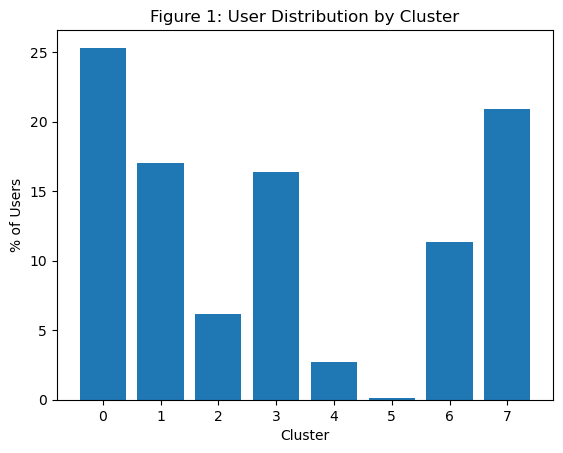

In [ ]:
# 3️⃣ Plot Figure 1: User Distribution by Cluster
plt.figure()
plt.bar(summary["cluster"], summary["pct_of_users"])
plt.xlabel("Cluster")
plt.ylabel("% of Users")
plt.title("Figure 1: User Distribution by Cluster")
plt.show()

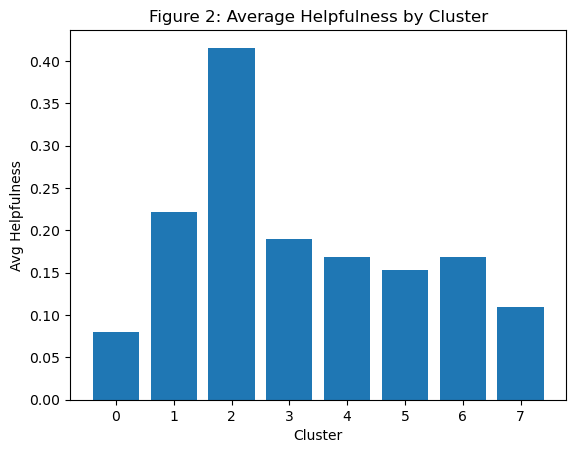

In [ ]:
# 4️⃣ Plot Figure 2: Average Helpfulness by Cluster
plt.figure()
plt.bar(summary["cluster"], summary["avg_helpfulness"])
plt.xlabel("Cluster")
plt.ylabel("Avg Helpfulness")
plt.title("Figure 2: Average Helpfulness by Cluster")
plt.show()

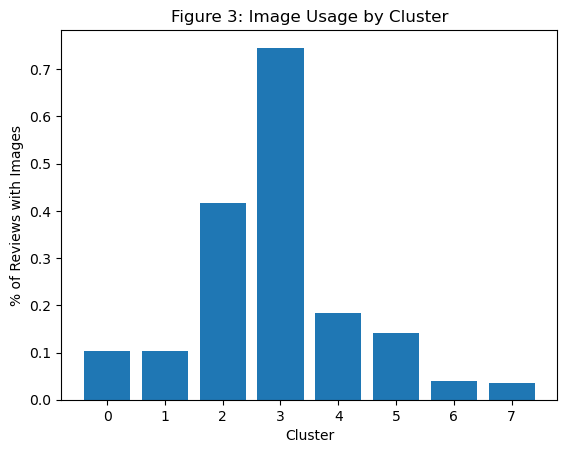

In [ ]:
# 5️⃣ Plot Figure 3: Image Usage by Cluster
plt.figure()
plt.bar(summary["cluster"], summary["avg_pct_images"])
plt.xlabel("Cluster")
plt.ylabel("% of Reviews with Images")
plt.title("Figure 3: Image Usage by Cluster")
plt.show()

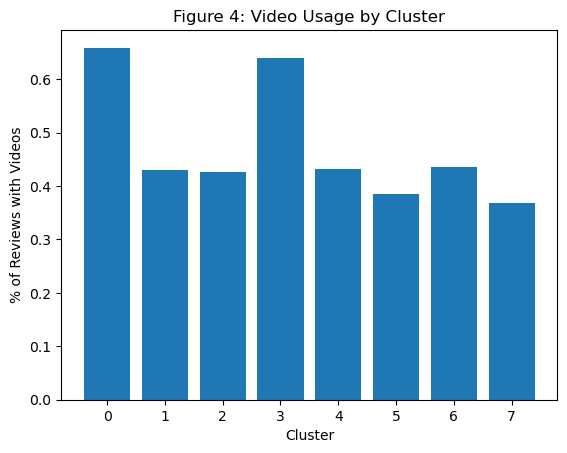

In [ ]:
# 6️⃣ Plot Figure 4: Video Usage by Cluster
plt.figure()
plt.bar(summary["cluster"], summary["avg_pct_videos"])
plt.xlabel("Cluster")
plt.ylabel("% of Reviews with Videos")
plt.title("Figure 4: Video Usage by Cluster")
plt.show()

-----

In [ ]:
summary

,cluster,count_users,avg_helpfulness,avg_pct_images,avg_pct_videos,pct_of_users
0,0,1114,0.080342,0.103959,0.659028,25.323937
1,1,749,0.222171,0.103743,0.430489,17.026597
2,2,272,0.415697,0.416653,0.425831,6.183223
3,3,720,0.189246,0.745428,0.640256,16.367356
4,4,120,0.168024,0.183290,0.432516,2.727893
5,5,4,0.152897,0.141540,0.384696,0.090930
6,6,499,0.168126,0.039108,0.434779,11.343487
7,7,921,0.109604,0.036388,0.369102,20.936576


# Cluster-Based User Segments: Key Insights & Recommendations

Below is a high-level summary of each user segment (clusters 0–7), followed by actionable, decision-driven recommendations your business can take.

| Cluster | % of Users | Avg Helpfulness | % with Images | % with Videos |
|:-------:|:----------:|:---------------:|:-------------:|:-------------:|
| **0**   | 25.32%     | 0.0803          | 10.40%        | 65.90%        |
| **1**   | 17.03%     | 0.2222          | 10.37%        | 43.05%        |
| **2**   |  6.18%     | 0.4157          | 41.67%        | 42.58%        |
| **3**   | 16.37%     | 0.1892          | 74.54%        | 64.03%        |
| **4**   |  2.73%     | 0.1680          | 18.33%        | 43.25%        |
| **5**   |  0.09%     | 0.1529          | 14.15%        | 38.47%        |
| **6**   | 11.34%     | 0.1681          |  3.91%        | 43.48%        |
| **7**   | 20.94%     | 0.1096          |  3.64%        | 36.91%        |

---

## Segment Profiles & Business Implications

### Cluster 0: “Video-First Low-Helpfulness” (25.3%)
- **Behavior**: Very low helpfulness (0.08), high video usage (~66%), low image inclusion.  
- **Implications**: Deploy guided review prompts (e.g. “What stood out most?”) to add context to their videos.

### Cluster 1: “Balanced Video & Text” (17.0%)
- **Behavior**: Moderate helpfulness (0.22), ~43% include video, ~10% include images.  
- **Implications**: Incentivize image uploads (e.g. “Add a photo for 10% off”) to enrich their reviews.

### Cluster 2: “High-Help Multimedia Champions” (6.2%)
- **Behavior**: Highest helpfulness (0.42), ~42% images, ~43% videos.  
- **Implications**: Feature their UGC in testimonials, social galleries, and loyalty-program showcases.

### Cluster 3: “Image-First Enthusiasts” (16.4%)
- **Behavior**: Very high image usage (74.5%), high video (64%), decent helpfulness (0.19).  
- **Implications**: Run #PhotoContest campaigns and spotlight their photos on product pages.

### Cluster 4: “Mixed-Content Contributors” (2.7%)
- **Behavior**: Moderate media (18% images, 43% videos), helpfulness ~0.17.  
- **Implications**: Offer quick “one-click” media tips in-form to boost both image and video content.

### Cluster 5: “Ultra-Rare Micro-Reviewers” (0.1%)
- **Behavior**: Tiny group, limited media (14% images, 38% videos), moderate helpfulness.  
- **Implications**: Consider manual outreach or exclude from broad segmentation—focus on larger clusters.

### Cluster 6: “Text-Focused Occasional Video” (11.3%)
- **Behavior**: Very low images (4%), moderate videos (43%), helpfulness ~0.17.  
- **Implications**: Encourage image addition via gamified prompts (“Post a pic to earn a badge”).

### Cluster 7: “Pure Text Reviewers” (20.9%)
- **Behavior**: Minimal media (4% images, 37% videos), low helpfulness (0.11).  
- **Implications**: Use text-focused microcopy (“Tell us more in two lines!”) plus “Review + Photo = Prize” nudges.

---

## Strategic Recommendations

1. **Tailor Engagement by Cluster**  
   - **Clusters 2 & 3**: Spotlight their multimedia content in galleries and social channels.  
   - **Clusters 0 & 7**: Embed context-adding prompts and media-upload incentives in the review form.

2. **Optimize Review Quality**  
   - **Cluster 0**: Step-by-step guided questions to boost helpfulness.  
   - **Cluster 1 & 6**: Photo-upload calls-to-action to complement existing video/text mix.

3. **Product & UX Improvements**  
   - Leverage text feedback from **Clusters 6 & 7** for rapid sentiment-driven fixes.  
   - Surface negative one-liners in **Cluster 7** for fast priority issue resolution.

4. **Personalized Communications**  
   - **Email Campaigns**:  
     - “Photo of the Month” invites for Clusters 2 & 3.  
     - “Quick Review Tips” for Clusters 0 & 7.  
   - **On-Site Microcopy**: Tailor prompts by segment (e.g., “Show us a pic!” vs. “Tell us what you loved!”).

5. **Loyalty & Retention**  
   - Identify top performers (helpfulness + media share) across clusters and enroll them in an exclusive “Reviewer Hall of Fame” with perks.

---

By aligning these tactics and incentives to each of your eight distinct segments, you’ll drive richer, more helpful reviews and stronger brand advocacy across your user base.  

---

## Clustering Methodology & Dashboard Customization

- **Chosen Algorithm:** K-Means ( *k* = 8 )  
- **Evaluation:** Average silhouette score ≈ 0.23 (on 2-D PCA projection)  
- **Why This Setup?**  
  - Eight clusters provided the finest balance of distinct, actionable personas and cluster separation among the methods tested.  
- **Interactive Tuning:**  
  - In the notebook’s **Interactive Clustering** section, switch between **K-Means**, **DBSCAN**, and **Agglomerative**.  
  - Adjust the **k-slider** (for K-Means), **ε**, and **min_samples** controls to re-fit and visualize your new segmentations instantly.  
  - Watch the silhouette score update in real time to identify the optimal configuration for your data.  

By experimenting with algorithms and hyperparameters—and observing both scatter/dendrogram plots and silhouette metrics—you can zero in on the segmentation that best supports your marketing, product development, or loyalty strategies.  


----

In [ ]:
spark.stop()

In [ ]:
# user_df.to_csv('gs://ba843-group1-project/Analysis Files/cluster_df.csv', index=False, storage_options={"token": "cloud"})